In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import h5py
from scipy import optimize

%load_ext autoreload
%autoreload 2

rc('text', usetex=False)
rc('font', family='serif', size=20)
rc('figure', figsize=(12,8))
rc('axes',linewidth=2)

# Funzioni utili

In [2]:
from scipy.signal import welch

def PSD(esignal_matrix,t_sample,wind = "hann"): 
    '''
    signal_matrix una matrice di eventi di rumore (esignal_matrix) e il tempo di campionamento (t_sample), valuta la PSD
    '''
    wind     = wind
    npt      = esignal_matrix.shape[1]
        
    f, pxx = welch(esignal_matrix,fs=1./t_sample, window=wind, nperseg=npt, scaling='density', axis=1)
    mean_true_scale = np.mean(pxx, axis = 0)
        
    f = np.append( f[:-1], -1*f[1:][::-1])
    mean_true_scale = np.append( mean_true_scale[:-1],  mean_true_scale[1:][::-1] ) 
    mean_use_scale  = mean_true_scale* (1./t_sample*esignal_matrix.shape[1]/2.)    #correct?
        
    return f, mean_use_scale, mean_true_scale

In [19]:
import pandas as pd

C:\Users\ricca\AppData\Local\Temp\ipykernel_10792\4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [70]:
df = pd.read_csv('RC.csv')

In [71]:
nu = df['X--Trace 1::[AC: FREQUENCY]']

In [72]:
mag = df['Mag: PR1: V(4)']

In [73]:
nu = nu[np.where(nu<1e8)[0]]
mag = mag[np.where(nu<1e8)[0]]

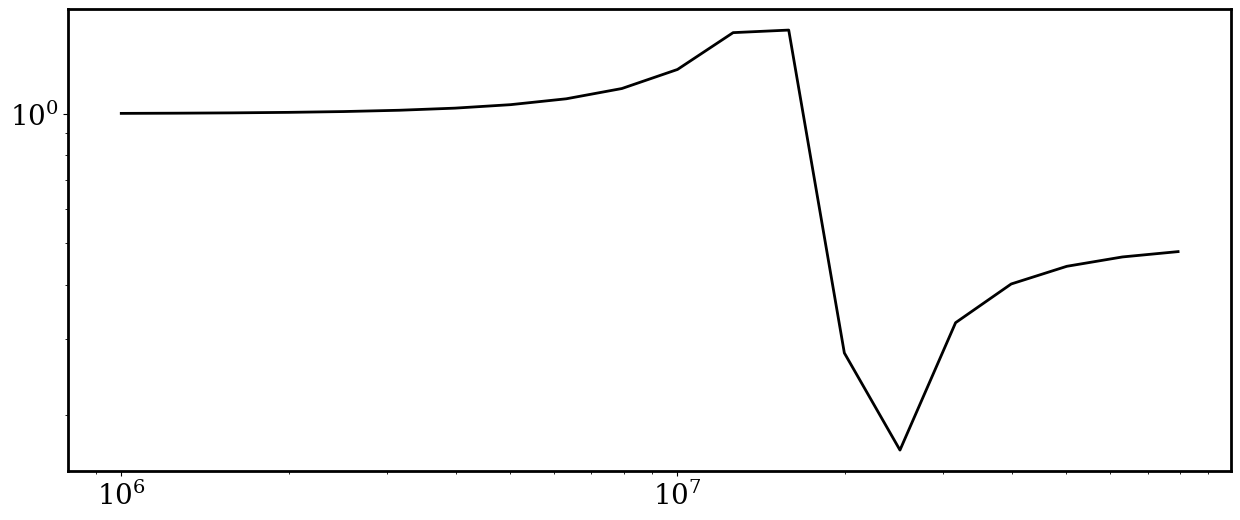

In [74]:
fig, ax = plt.subplots(1,1,figsize=(15,6))
ax.loglog(nu,mag,c='k',label='With RC Filter', linewidth=2)

In [14]:
import os
path = r'C:\Users\ricca\Desktop\MAGISTRALE\QTLab2324\DATA ANALYSIS\OPTIMUM\MOD\\'
RC,RC_noise = [], []
for filename in os.walk(path):
    for file in filename[2]:
                with h5py.File(path+file,'r') as file:
                        for key in file.keys():
                            if 'Noise' in key:
                                RC_noise.append(np.array(file[key][:])[:20000])
                            elif 'Raw' in key:
                                RC.append(np.array(file[key][:])[:20000])

In [15]:
preStop = 950  #E' il numero di punti della finestra di acquisizione senza il segnale.
RC = np.array(RC)
RC_noise = np.array(RC_noise[:len(RC)])

In [16]:
bsl = np.mean(RC[:,0:preStop],axis=1)
bsl_noise = np.mean(RC_noise,axis=1)

#Faccio in modo tale che i dati e il rumore partano da 0

RC = -1*(RC - np.array([bsl]).T )
RC_noise = -1*(RC_noise - np.array([bsl_noise]).T)

In [17]:
# Calcolo la PSD del rumore, il primo ingrediente del filtro ottimo
t_samp = 1/1e8   #in secondi

freq_noise_RC, PSD_noise_RC, _ = PSD(RC_noise[:,:RC_noise.shape[1]],t_samp)
freq_sig_RC, PSD_sig_RC, _ = PSD(np.array([RC[1]]),t_samp)

npt_noise = PSD_noise_RC.shape[0]
npt_sig = PSD_sig_RC.shape[0]
print(npt_sig)

20000


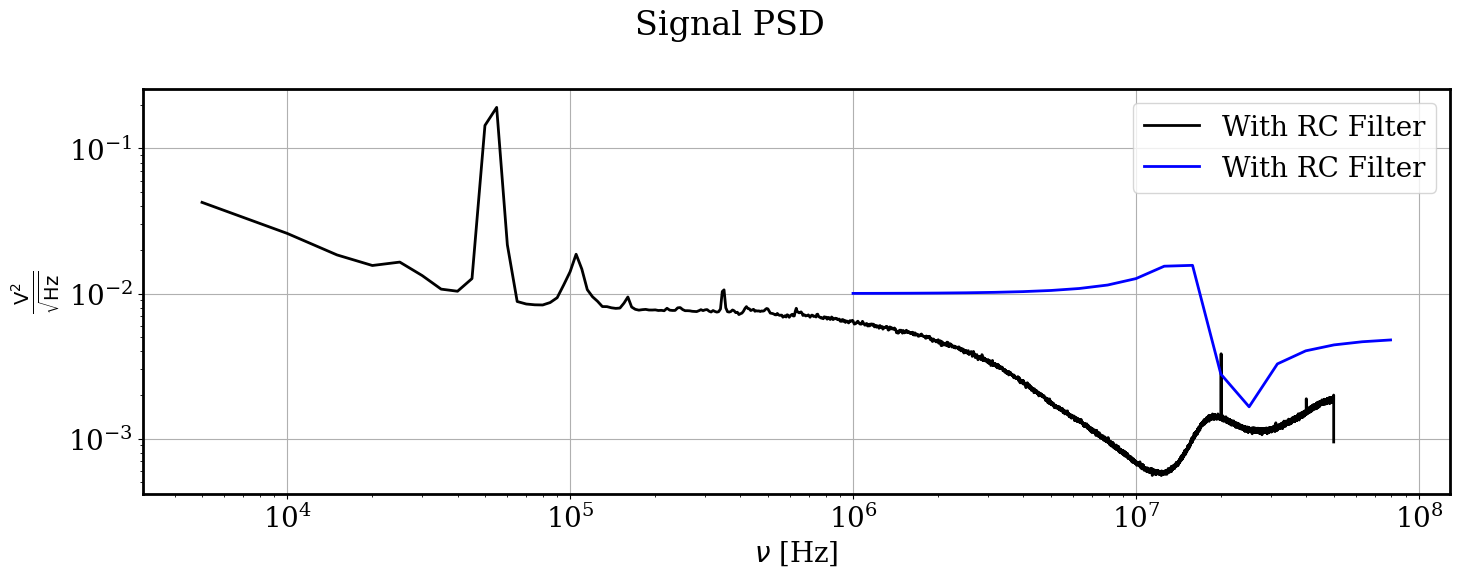

In [80]:
fig, ax = plt.subplots(1,1,figsize=(15,6))
ax.loglog(-1*freq_sig_RC[npt_sig//2:][::-1],PSD_noise_RC[npt_sig//2:][::-1],c='k',label='With RC Filter', linewidth=2)
ax.loglog(nu,1e-2*mag,c='b',label='With RC Filter', linewidth=2)
#ax[0].loglog(-1*freq_sig_NORC[npt_sig//2:][::-1],PSD_noise_NORC[npt_sig//2:][::-1],c='b',label='No RC Filter', linewidth=2, linestyle='--',alpha=0.5)
#ax[1].loglog(-1*freq_sig_NORC[npt_sig//2:][::-1],PSD_noise_NORC[npt_sig//2:][::-1],c='b',label='No RC Filter', linewidth=2)
ax.set_xlabel(r"$\nu$ [Hz]")
ax.set_ylabel(r"$\frac{\text{V}^{2}}{\sqrt{\text{Hz}}}$")
#ax.set_xlabel(r"$\nu$ [Hz]")
#ax.set_ylabel(r"$\frac{\text{V}^{2}}{\sqrt{\text{Hz}}}$")
ax.legend()
ax.grid()
#ax[1].legend()
#ax[1].grid()
fig.suptitle('Signal PSD')
fig.tight_layout()

In [86]:
f = -1*freq_sig_RC[npt_sig//2:][::-1][np.where(freq_sig_RC>1e6)[0]]
m = PSD_noise_RC[npt_sig//2:][::-1][np.where(freq_sig_RC>1e6)[0]]

In [104]:
def transfer_function_magnitude(f, R, C, L):
    omega = 2 * np.pi * f
    return 1e-3*(1 / (omega * C)) / np.sqrt(R**2 + (1 / (omega * C) - omega * L)**2)

In [100]:
from scipy.optimize import curve_fit

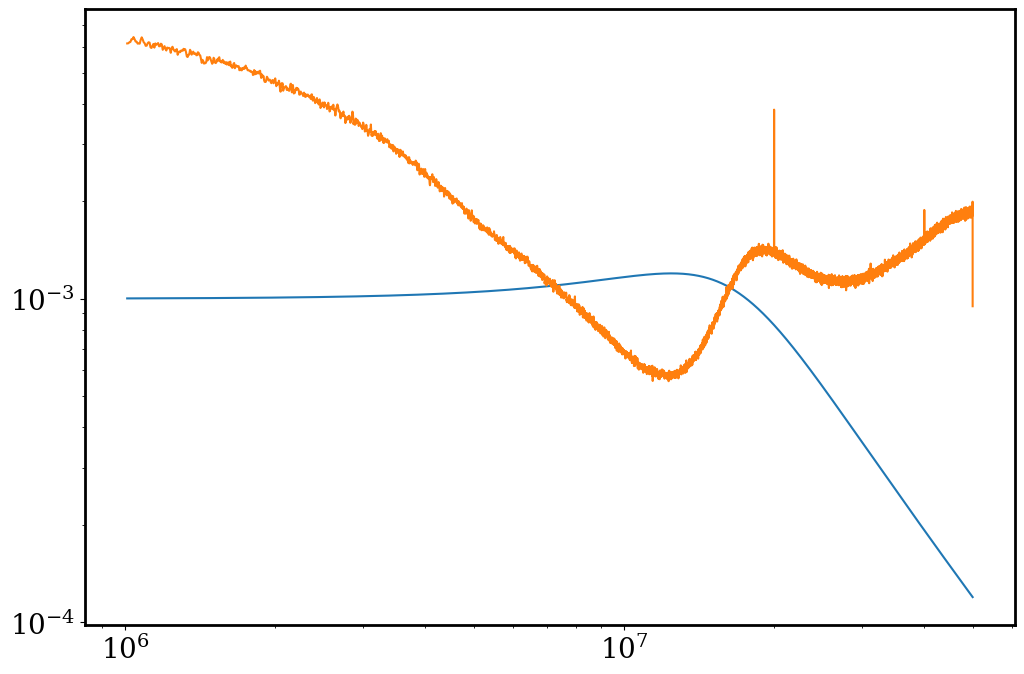

In [110]:
plt.loglog(f,transfer_function_magnitude(f,1,9*1e-9,1e-8))
plt.loglog(f,m)

In [105]:
popt, pcov = curve_fit(transfer_function_magnitude,f,m)

C:\Users\ricca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


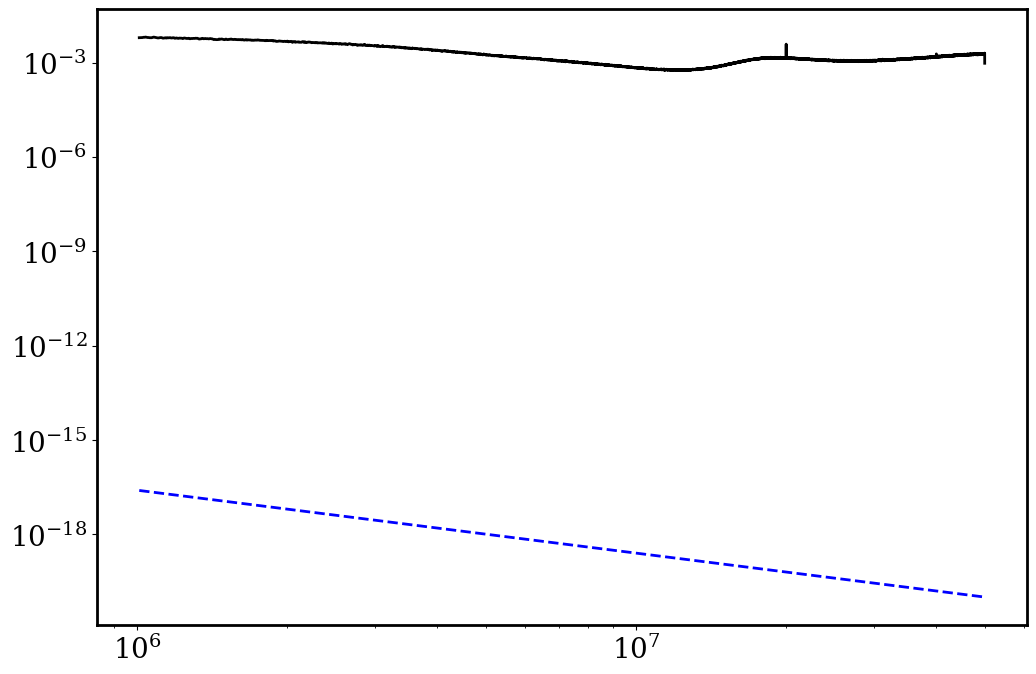

In [107]:
plt.loglog(f,m,label='data',linestyle='-',color='k',linewidth=2)
plt.loglog(f,transfer_function_magnitude(f,*popt),label='fit',linestyle='--',color='b',linewidth=2)

In [31]:
# Calcolo il segnale atteso (medio), l'ultimo ingrediente per il filtro ottimo

medium = Medium(NPS = PSD_noise)
medium.create_medium(signal_matrix,np.zeros(signal_matrix.shape[0]))
medium_pulse = medium.get_medium()

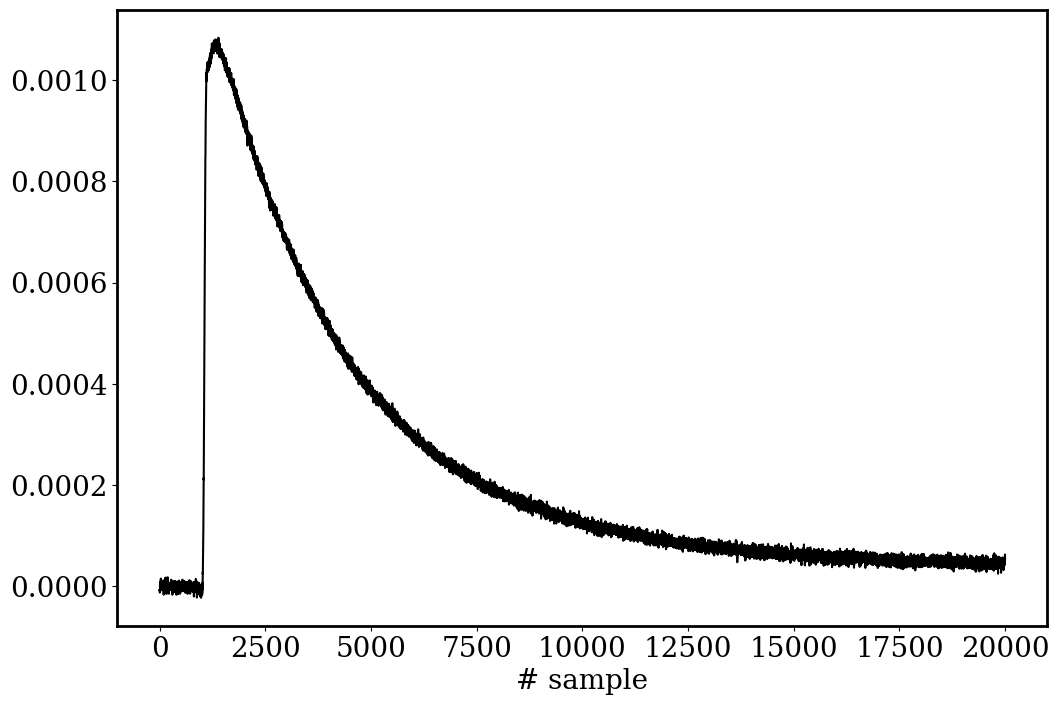

In [32]:
plt.plot(medium_pulse,c='k')
plt.xlabel("# sample")
plt.show()

In [33]:
# Creo il filtro H e lo applico ai dati su cui ho calcolato il medio
H = create_filter(medium_pulse,PSD_noise)

signal_matrix_filtered_f =  np.fft.fft(signal_matrix, axis=1)*H # dati filtrati dominio freq
signal_matrix_filtered_t =  np.fft.ifft(signal_matrix_filtered_f).real   #dati filtrati dominio temp
signal_matrix_filtered_t =  np.concatenate((signal_matrix_filtered_t[:,int(signal_matrix_filtered_t.shape[1]/2):signal_matrix_filtered_t.shape[1]], signal_matrix_filtered_t[:,0:int(signal_matrix_filtered_t.shape[1]/2)]),axis=1)

noise_matrix_filtered_f =  np.fft.fft(noise_matrix, axis=1)*H # dati filtrati dominio freq
noise_matrix_filtered_t =  np.fft.ifft(noise_matrix_filtered_f).real   #dati filtrati dominio temp
noise_matrix_filtered_t =  np.concatenate((noise_matrix_filtered_t[:,int(noise_matrix_filtered_t.shape[1]/2):noise_matrix_filtered_t.shape[1]], noise_matrix_filtered_t[:,0:int(signal_matrix_filtered_t.shape[1]/2)]),axis=1)

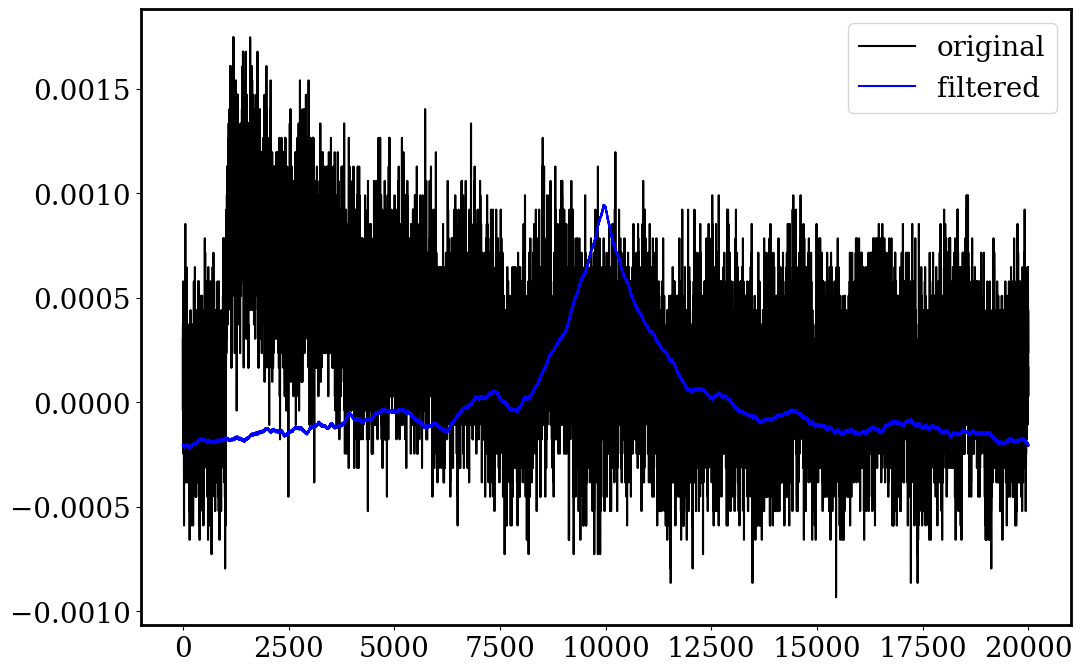

In [34]:
#Guardo come cambiano i dati prima e dopo il filtro ottimo
nev = 10
#===================
plt.plot(signal_matrix[nev],c='k',label="original")
plt.plot(signal_matrix_filtered_t[nev],label="filtered",c='b')
plt.legend()
plt.show()

In [35]:
H.shape

(20000,)

In [36]:
with open('Filter.txt','w') as f:
    for h in H:
        f.writelines(str(h.real)+'\t'+str(h.imag)+'\n')

# Applico il filtro ottimo per valutare l'ampiezza dei dati

In [37]:
OFT, OFF, OFdelay, OFtest = applyOF(signal_matrix,H)

# OFT è l'ampiezza del segnale, calcolata con il filtro ottimo nel dominio del tempo
# OFF è l'ampiezza del segnale, calcolata con il filtro ottimo nel dominio delle frequenze, dovrebbe essere uguale
#     (o molto simile) a OFT
# OFdelay e OFtest ignoratele.

In [38]:
with open('OFF_Tension.txt','w') as f:
    for o in OFF:
        f.writelines(str(o)+'\n')

with open('OFT_Tension.txt','w') as f:
    for o in OFT:
        f.writelines(str(o)+'\n')

In [39]:
OFT_noise, OFF_noise, _, _ = applyOF(noise_matrix,H) 

In [40]:
np.sqrt(abs(np.mean(medium_pulse[:700])))

0.0008855764274782089